<a href="https://colab.research.google.com/github/Knarendra4986/Dense-U-Net_Urban_Builtup_Extraction/blob/main/Dense_Unet_Building_Mapping1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building Mapping




In [ ]:
!pip install tensorflow

In [ ]:
# import necessary libraries
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout

In [ ]:
# connect google drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# set the working directory
import os
os.chdir(r'/content/gdrive/MyDrive/satellite img proj -colab')

## Data preprocessing

In [ ]:
train_x = sorted(glob.glob('train/*_image.tif'))
train_y = sorted(glob.glob('train/*_label.tif'))
test_x = sorted(glob.glob('test/*_image.tif'))
test_y = sorted(glob.glob('test/*_label.tif'))

print(len(train_x), len(test_x))

70 30


In [ ]:
# converting training image to numpy array
train_xx = np.zeros((70, 128, 128, 3))
train_yy = np.zeros((70, 128, 128, 1))
for i, (img, mask) in enumerate(zip(train_x, train_y)):
  # if i == 1:
  #   break

  img = Image.open(img)
  np_img = np.array(img)
  train_xx[i] = np_img

  mask = Image.open(mask)
  np_mask = np.array(mask).reshape(128, 128, 1)
  train_yy[i] = np_mask

In [ ]:
# converting training image to numpy array
test_xx = np.zeros((30, 128, 128, 3))
test_yy = np.zeros((30, 128, 128, 1))
for i, (img, mask) in enumerate(zip(test_x, test_y)):

  img = Image.open(img)
  np_img = np.array(img)
  test_xx[i] = np_img

  mask = Image.open(mask)
  np_mask = np.array(mask).reshape(128, 128, 1)
  test_yy[i] = np_mask

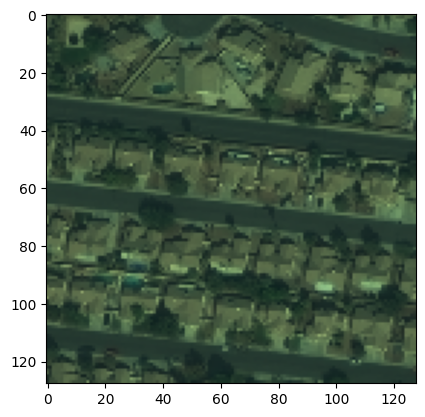

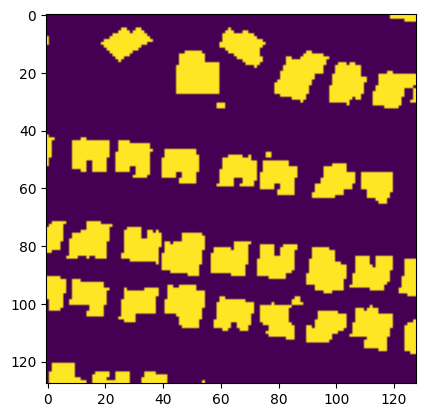

In [ ]:
# Let's plot a sample input RGB image and output image with buildings

plt.imshow(train_xx[16, :, :, :].astype('uint8'))
plt.show()
plt.imshow(train_yy[16, :, :, 0].astype('uint8'))
plt.show()

## Save to numpy format

In [ ]:
train_xx.shape

(70, 128, 128, 3)

In [ ]:
np.save('/content/gdrive/MyDrive/satellite img proj -colab/train_xx.npy', train_xx)
np.save('/content/gdrive/MyDrive/satellite img proj -colab/train_yy.npy', train_yy)
np.save("/content/gdrive/MyDrive/satellite img proj -colab/test_xx.npy", test_xx)
np.save("/content/gdrive/MyDrive/satellite img proj -colab/test_yy.npy", test_yy)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model

def dense_block(x, filters):
    """Creates a dense convolutional block."""
    for _ in range(3):
        conv = Conv2D(filters, (3,3), padding='same')(x)
        conv = BatchNormalization()(conv)
        conv = Activation('relu')(conv)
        x = Concatenate()([x, conv])
    return x

def transition_layer(x, filters):
    """Creates a transition layer for downsampling."""
    x = Conv2D(filters, (1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2,2))(x)
    return x

def DenseUNet(input_shape=(128, 128, 3)):
    """Builds a Dense U-Net model."""
    inputs = Input(input_shape)

    # Encoder
    d1 = dense_block(inputs, 32)
    t1 = transition_layer(d1, 64)
    d2 = dense_block(t1, 64)
    t2 = transition_layer(d2, 128)
    d3 = dense_block(t2, 128)
    t3 = transition_layer(d3, 256)

    # Bottleneck
    b = dense_block(t3, 256)

    # Decoder
    u1 = UpSampling2D((2,2))(b)
    u1 = Concatenate()([u1, d3])
    u1 = dense_block(u1, 128)

    u2 = UpSampling2D((2,2))(u1)
    u2 = Concatenate()([u2, d2])
    u2 = dense_block(u2, 64)

    u3 = UpSampling2D((2,2))(u2)
    u3 = Concatenate()([u3, d1])
    u3 = dense_block(u3, 32)

    outputs = Conv2D(1, (1,1), activation='sigmoid')(u3)

    model = Model(inputs, outputs)
    return model

# Build and compile the model
model = DenseUNet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_24      │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│ (Concatenate)       │ 35)               │            │ activation_24[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 128, 128,  │     10,112 │ concatenate_24[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_25      │ (None, 128, 128,  │          0 │ concatenate_24[0… │
│ (Concatenate)       │ 67)               │            │ activation_25[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 128, 128,  │     19,328 │ concatenate_25[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_26      │ (None, 128, 128,  │          0 │ concatenate_25[0… │
│ (Concatenate)       │ 99)               │            │ activation_26[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 128, 128,  │      6,400 │ concatenate_26[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ activation_27[0]

 Total params: 16,641,284 (63.48 MB)

 Trainable params: 16,636,164 (63.46 MB)

 Non-trainable params: 5,120 (20.00 KB)

In [ ]:
# training model
history = model.fit(train_xx, train_yy, validation_data=(test_xx, test_yy), epochs=100, batch_size=10, verbose=1)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7570 - loss: 1.6018 - val_accuracy: 0.7633 - val_loss: 1103.1816
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8501 - loss: 0.3939 - val_accuracy: 0.7680 - val_loss: 1537.4991
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8531 - loss: 0.3400 - val_accuracy: 0.7546 - val_loss: 243.2609
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8716 - loss: 0.2972 - val_accuracy: 0.7627 - val_loss: 114.8109
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8884 - loss: 0.2643 - val_accuracy: 0.7554 - val_loss: 28.7254
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8954 - loss: 0.2490 - val_accuracy: 0.7501 - val_loss: 10.4276
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9059 - loss: 0.2278 - val_accuracy: 0.7482 - val_loss: 1.6610
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9107 - loss: 0.2177 - val_accuracy: 0.6472 - val_los

x_train shape (70, 128, 128, 3)
y_train shape (70, 128, 128, 1)
y_test shape (30, 128, 128, 3)
y_test shape (30, 128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


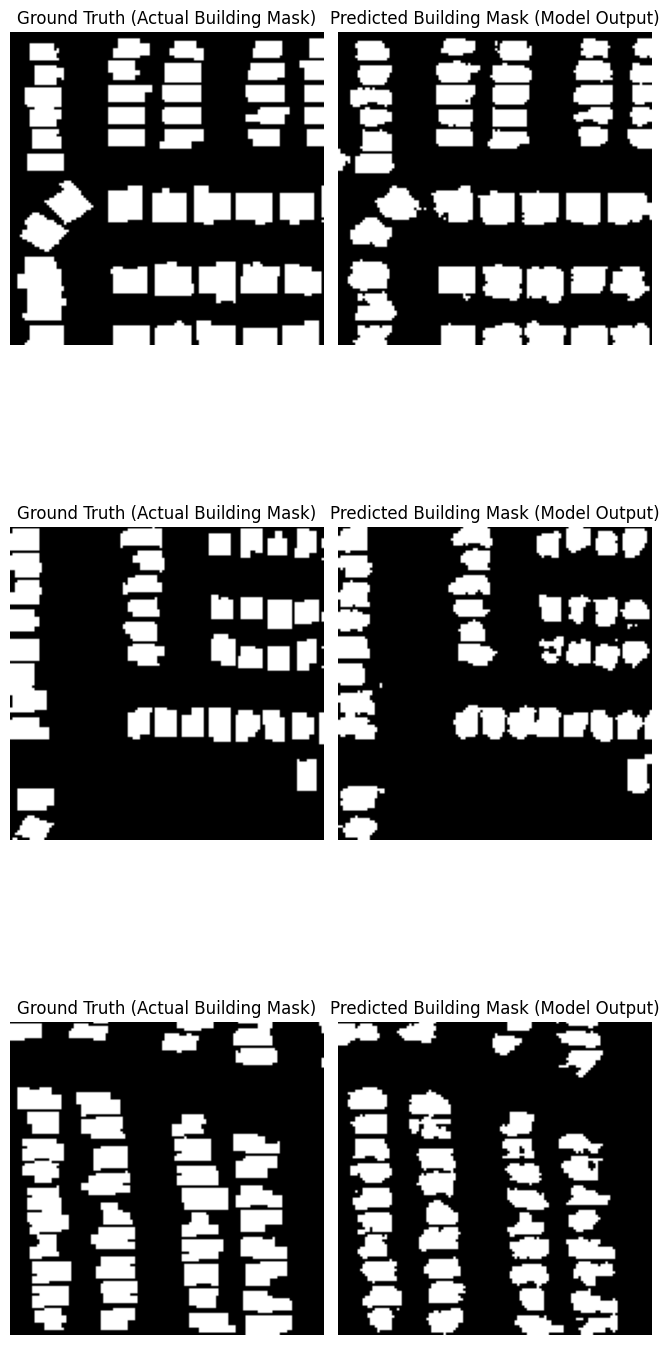

In [ ]:
import matplotlib.pyplot as plt

# Function to display original image, ground truth, and predicted mask
def visualize_results(model, test_images, test_masks, num_samples=3):
    """Displays original satellite images, ground truth masks, and model predictions."""
    pred_masks = model.predict(test_images)  # Generate predictions
    pred_masks = (pred_masks > 0.5).astype(np.uint8)  # Apply thresholding

    plt.figure(figsize=(10, num_samples * 5))

    for i in range(num_samples):
        idx = np.random.randint(0, len(test_images))  # Pick a random test image

        # Ground Truth Mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(test_masks[idx].squeeze(), cmap="gray")
        plt.title("Ground Truth (Actual Building Mask)")
        plt.axis("off")

        # Predicted Mask by Model
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_masks[idx].squeeze(), cmap="gray")
        plt.title("Predicted Building Mask (Model Output)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Call the function to visualize predictions
# data is already randomized and split in to training / test sets. So we can go ahead and use them as it is.
x_train = np.load('train_xx.npy').astype('float32')
y_train= np.load('train_yy.npy').astype('float32')
x_test = np.load('test_xx.npy').astype('float32')
y_test = np.load('test_yy.npy').astype('float32')

print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("y_test shape", x_test.shape)
print("y_test shape", y_test.shape)
visualize_results(model, x_test, y_test, num_samples=3)


# Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
(30, 128, 128, 1)


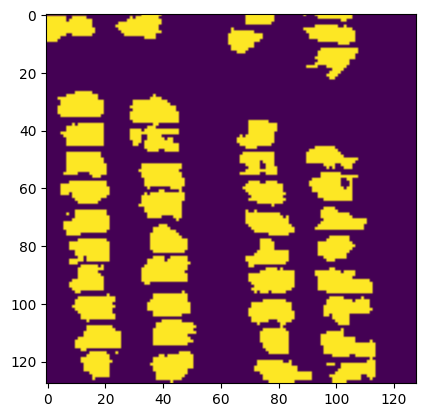

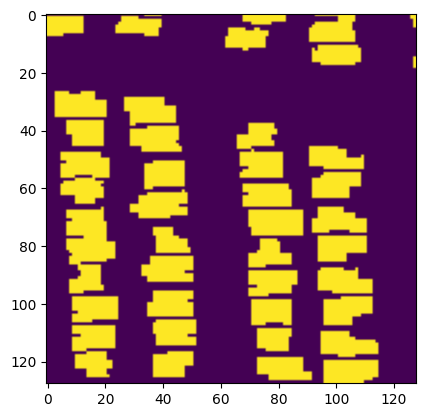

In [ ]:
threshold = 0.5

# prediction of the output
pred_test = model.predict(test_xx)
pred_test = (pred_test > threshold).astype(np.uint8)
print(pred_test.shape)

#let's comare random predicted and actial y values
plt.imshow(pred_test[15, :, :, 0])
plt.show()
plt.imshow(test_yy[15,:,:,0])
plt.show()

This is not an operational model with high accuracy. But with more layers and with more data, we can develop this architecture in to an operational model with high accuracy.

## Convert numpy array to image

In [ ]:
from PIL import Image
import os
def convert_numpy_array_to_img(in_npy, out_folder, channel=3):
    n = in_npy.shape[0]
    for i in range(n):
        if channel==3:
            image = Image.fromarray(in_npy[i].astype('uint8'))
            image.save(os.path.join(out_folder, f"{i}_image.tif"))

        else:
            image = Image.fromarray(in_npy[i, :, :, 0])
            image.save(os.path.join(out_folder, f"{i}_label.tif"))

In [ ]:
convert_numpy_array_to_img(x_train, 'train')
convert_numpy_array_to_img(y_train, 'train', channel=1)

convert_numpy_array_to_img(x_test, 'test')
convert_numpy_array_to_img(y_test, 'test', channel=1)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Functions for IoU and Dice
def compute_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 0.0

def compute_dice(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred)) if (np.sum(y_true) + np.sum(y_pred)) != 0 else 0.0

# Function to evaluate and visualize one image
def evaluate_single_image(index):
    img = x_test[index]
    true_mask = y_test[index].squeeze()

    # Predict mask
    pred = model.predict(np.expand_dims(img, axis=0))[0]
    pred_mask = (pred > 0.5).astype(np.uint8).squeeze()

    # Flatten masks
    y_true = true_mask.flatten().astype(np.uint8)
    y_pred = pred_mask.flatten().astype(np.uint8)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    iou = compute_iou(y_true, y_pred)
    dice = compute_dice(y_true, y_pred)

    # Display results
    print(f"📸 Evaluation for Test Image {index + 1}")
    print(f"Accuracy        : {acc:.4f}")
    print(f"Precision       : {prec:.4f}")
    print(f"Recall          : {rec:.4f}")
    print(f"F1 Score        : {f1:.4f}")
    print(f"IoU             : {iou:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")

    # Plot visual comparison
    plt.figure(figsize=(10, 3))

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
📸 Evaluation for Test Image 8
Accuracy        : 0.9269
Precision       : 0.8838
Recall          : 0.8581
F1 Score        : 0.8708
IoU             : 0.7711
Dice Coefficient: 0.8708


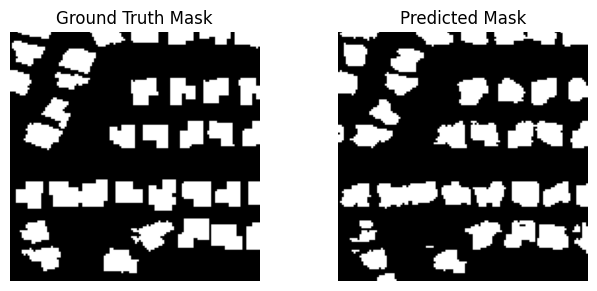

In [ ]:
evaluate_single_image(7)  # Change 0 to any index from your test set


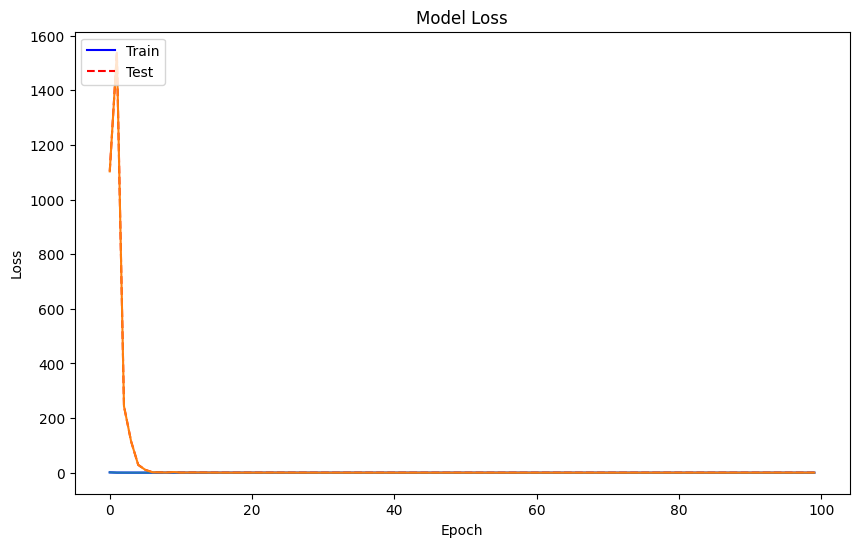

In [ ]:
import matplotlib.pyplot as plt

# plot model loss over training and validation data
plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization

# Customize line styles and colors
plt.plot(history.history['loss'], label='Train Loss', color='blue', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

def compute_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 0.0

def compute_dice(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred)) if (np.sum(y_true) + np.sum(y_pred)) != 0 else 0.0

# Predict masks for all test images
pred_masks = model.predict(x_test)
pred_masks = (pred_masks > 0.5).astype(np.uint8)

# Loop over each test sample and print metrics
for i in range(len(x_test)):
    y_true = y_test[i].flatten().astype(np.uint8)
    y_pred = pred_masks[i].flatten().astype(np.uint8)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    iou = compute_iou(y_true, y_pred)
    dice = compute_dice(y_true, y_pred)

    print(f"\n📸 Image {i+1}")
    print(f"Accuracy        : {acc:.4f}")
    print(f"Precision       : {prec:.4f}")
    print(f"Recall          : {rec:.4f}")
    print(f"F1 Score        : {f1:.4f}")
    print(f"IoU             : {iou:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")

    # Helper functions
def compute_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 0.0

def compute_dice(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred)) if (np.sum(y_true) + np.sum(y_pred)) != 0 else 0.0

# Predict masks
pred_masks = model.predict(x_test)
pred_masks = (pred_masks > 0.5).astype(np.uint8)

# Prepare results storage
results = []

# Evaluate each test image
for i in range(len(x_test)):
    y_true = y_test[i].flatten().astype(np.uint8)
    y_pred = pred_masks[i].flatten().astype(np.uint8)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    iou = compute_iou(y_true, y_pred)
    dice = compute_dice(y_true, y_pred)

    results.append({
        "Image": i + 1,
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1 Score": round(f1, 4),
        "IoU": round(iou, 4),
        "Dice Coefficient": round(dice, 4)
    })

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Display the performance table
print(df_results)

# Optional: Save to CSV file
# df_results.to_csv("test_image_performance_metrics.csv", index=False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step

📸 Image 1
Accuracy        : 0.9430
Precision       : 0.8772
Recall          : 0.8064
F1 Score        : 0.8403
IoU             : 0.7246
Dice Coefficient: 0.8403

📸 Image 2
Accuracy        : 0.9182
Precision       : 0.8635
Recall          : 0.8769
F1 Score        : 0.8701
IoU             : 0.7701
Dice Coefficient: 0.8701

📸 Image 3
Accuracy        : 0.9169
Precision       : 0.8728
Recall          : 0.8502
F1 Score        : 0.8613
IoU             : 0.7564
Dice Coefficient: 0.8613

📸 Image 4
Accuracy        : 0.9167
Precision       : 0.8443
Recall          : 0.7383
F1 Score        : 0.7877
IoU             : 0.6498
Dice Coefficient: 0.7877

📸 Image 5
Accuracy        : 0.9384
Precision       : 0.8070
Recall          : 0.8984
F1 Score        : 0.8502
IoU             : 0.7395
Dice Coefficient: 0.8502

📸 Image 6
Accuracy        : 0.9150
Precision       : 0.8495
Recall          : 0.8091
F1 Score        : 0.8288
IoU             : 0.7076
Dice Coefficient: 0.